In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer, TfidfTransformer
from sklearn.svm import SVC, LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
import string
from pythainlp.tokenize import word_tokenize
import re
import matplotlib.font_manager as fm
from pathlib import Path
import urllib.request
import emoji

from imblearn.over_sampling import RandomOverSampler
from imblearn.pipeline import Pipeline as ImbPipeline
from sklearn.metrics import recall_score

from sklearn.pipeline import FeatureUnion
from sklearn.preprocessing import StandardScaler
from sklearn.base import BaseEstimator, TransformerMixin

pd.set_option("max_colwidth", 0)

In [3]:
def clean_text(text):
    if pd.isna(text):
        return text
    
    text = str(text)
    
    # Remove URLs
    text = re.sub(r'http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\\(\\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+', '', text)
    text = re.sub(r'www\.(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\\(\\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+', '', text)
    
    # Normalize emojis (convert to text description)
    text = emoji.demojize(text, language='en')
    
    return text.strip()

def lowercase_english(text):
    if pd.isna(text):
        return text
    
    result = []
    for char in str(text):
        # Check if character is English
        if ord(char) < 128:
            result.append(char.lower())
        else:
            result.append(char)
    
    return ''.join(result)

def calculate_thai_length(text):
    if pd.isna(text):
        return 0
    
    # Tokenize using PyThaiNLP
    tokens = word_tokenize(str(text), engine='newmm')
    return len(tokens)

In [4]:
def prepare_dataset(dataset_file):
    print(f"Processing {dataset_file}...")
    
    df = pd.read_csv(dataset_file)
    print(f"  Original shape: {df.shape}")
    
    # Handle missing labels (drop rows with missing category or texts)
    df = df.dropna(subset=['category', 'texts'])
    print(f"  After dropping missing labels: {df.shape}")
    
    # Clean text (remove URLs, normalize emojis)
    df['texts'] = df['texts'].apply(clean_text)
    
    # Lowercase English characters (keep Thai)
    df['texts'] = df['texts'].apply(lowercase_english)
    
    # Drop rows with empty texts after cleaning
    df = df[df['texts'].str.strip() != '']
    print(f"  After removing empty texts: {df.shape}")
    
    # Map labels - pos -> neu
    df['category'] = df['category'].replace({'pos': 'neu'})
    
    # map to binary: neg vs non-neg
    df['category'] = df['category'].map({'neg': 1, 'neu': 0})
    
    # Recalculate length using PyThaiNLP word tokenization
    df['length'] = df['texts'].apply(calculate_thai_length)
    
    # Add dataset source
    df['source'] = dataset_file.split('/')[-1]
    
    print(f"  Final shape: {df.shape}")
    print(f"  Label distribution: {df['category'].value_counts().to_dict()}")
    print()
    
    return df

In [5]:
df1 = prepare_dataset('datasets/dataset1.csv')
df2 = prepare_dataset('datasets/dataset2.csv')
df3 = prepare_dataset('datasets/dataset3.csv')
# df4 = prepare_dataset('datasets/dataset4.csv')
# df5 = prepare_dataset('datasets/dataset5.csv')
# df6 = prepare_dataset('datasets/dataset6.csv')

# # Combine all datasets
all_dfs = [df1, df2, df3]
combined_df = pd.concat(all_dfs, ignore_index=True)
print(f"Combined shape before deduplication: {combined_df.shape}")

# Remove duplicated samples
combined_df = combined_df.drop_duplicates(subset=['texts'], keep='first')
print(f"Combined shape after deduplication: {combined_df.shape}")

# Display final statistics
print(f"Total samples: {len(combined_df)}")
print(f"\nLabel distribution:")
print(combined_df['category'].value_counts())
print(f"\nLength statistics:")
print(combined_df['length'].describe())
print(f"\nDataset sources:")
print(combined_df['source'].value_counts())

Processing datasets/dataset1.csv...
  Original shape: (23545, 3)
  After dropping missing labels: (23545, 3)
  After removing empty texts: (23542, 3)
  Final shape: (23542, 4)
  Label distribution: {0: 17402, 1: 6140}

Processing datasets/dataset2.csv...
  Original shape: (2160, 3)
  After dropping missing labels: (2160, 3)
  After removing empty texts: (2160, 3)
  Final shape: (2160, 4)
  Label distribution: {1: 1332, 0: 828}

Processing datasets/dataset3.csv...
  Original shape: (4953, 3)
  After dropping missing labels: (4953, 3)
  After removing empty texts: (4953, 3)
  Final shape: (4953, 4)
  Label distribution: {0: 4428, 1: 525}

Combined shape before deduplication: (30655, 4)
Combined shape after deduplication: (30620, 4)
Total samples: 30620

Label distribution:
category
0    22634
1    7986 
Name: count, dtype: int64

Length statistics:
count    30620.000000
mean     42.733442   
std      124.195870  
min      1.000000    
25%      7.000000    
50%      16.000000   
75%      

In [ ]:
# def install_thai_font():
#     font_dir = Path.home() / '.fonts'
#     font_dir.mkdir(exist_ok=True)
#     font_path = font_dir / 'THSarabunNew.ttf'
    
#     if not font_path.exists():
#         print("Downloading TH Sarabun New font...")
#         url = "https://github.com/Phonbopit/sarabun-webfont/blob/master/fonts/thsarabunnew-webfont.ttf"
#         urllib.request.urlretrieve(url, font_path)
        
#         fm._rebuild()
#         print("Font installed successfully!")
#     else:
#         print("Font already installed.")

# install_thai_font()

# plt.rcParams['font.family'] = 'TH Sarabun New'
# plt.rcParams['axes.unicode_minus'] = False

# %matplotlib inline

def install_thai_font():
    font_dir = Path.home() / '.fonts'
    font_dir.mkdir(exist_ok=True)
    font_path = font_dir / 'THSarabunNew.ttf'
    
    if font_path.exists():
        os.remove(font_path)
    
    url = "https://github.com/Phonbopit/sarabun-webfont/raw/master/fonts/thsarabunnew-webfont.ttf"
    urllib.request.urlretrieve(url, font_path)
    fm.fontManager.addfont(str(font_path))
    print(f"Font installed and added: {font_path}")

install_thai_font()
plt.rcParams['font.family'] = 'TH Sarabun New'
plt.rcParams['axes.unicode_minus'] = False
found = any(['TH Sarabun New' in f.name for f in fm.fontManager.ttflist])
print(f"Is 'TH Sarabun New' in FontManager? {found}")

Font already installed.


In [20]:
df=combined_df.copy()

In [21]:
display(df.shape)
df.head()

(30620, 4)

,category,texts,length,source
0,1,อิเหี้ยออมทำกูอยากกินเอ็มเค,9,dataset1.csv
1,1,เน็ตควายมากกูพูดจริงเสียดายตังค์ที่ติดตั้งเน็ตโครตห่วยยิ่งดึกๆเน็ตยิ่งห่วยตอนมาติดตั้งใหม่ๆก็ดีนานๆไปเเย่ขึ้นเรื่อยๆกากกว่าเน็ตค่ายอื่นอ่ะบอกจริงไม่สนหรอกว่าจะเป็นเด็กเเล้วเม้นด่าเเบบนี้ เเต่นี้หาตังค์จ่ายค่าเน็ตมาตลอดเหนื่อยน่ะเล่นเกมส์ไปเดี่ยวก็หายกากเกินติดตั้งโปรพิเศษ100mเเต่พอวัดดูปล่อยไม่ถึงเท่าที่ตกลงกันไว้พอโทรไปเเจ้งก็ปล่อยมาเต็มไม่กี่วันก็เหมื่อนเดิมใบเเจ้งก็มาย้อนหลัง3เดือนทุกครั้งห่วยไปน่ะบางทีโปร100m/700 กว่าบาทเเต่คุณภาพเเย่เสียดายตังค์,127,dataset1.csv
2,1,เหล้าเบลล์รสชาติเหี้ยสุด จะไม่แดกอีกละ,11,dataset1.csv
3,1,ลิปมันของเเบร์น mistine ราคากลาง ๆ ไม่แพงมาก ราคาสามารถเอื้อมถึงได้ #lashesactivity,23,dataset1.csv
4,1,ทำไมมันไม่มีโปรให้เร๊าาาาาา,7,dataset1.csv


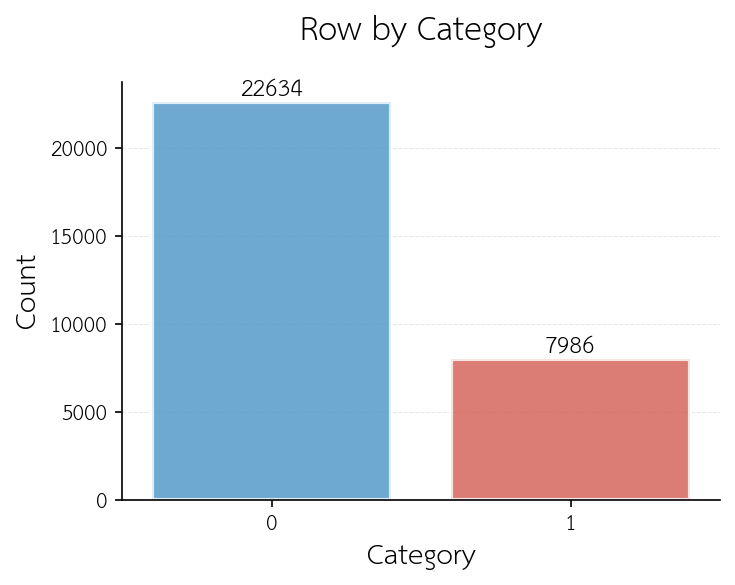

In [22]:
count_data = df.category.value_counts().reset_index()
count_data.columns = ['category', 'count']

fig, ax = plt.subplots(figsize=(5, 4), dpi=150)

sns.barplot(
    data=count_data,
    x='category',
    y='count',
    palette=['#3498db', '#e74c3c'],
    hue= 'category',
    alpha=0.8,
    edgecolor='white',
    linewidth=2,
    ax=ax,
    legend=False
)

ax.set_xlabel('Category', fontsize=13, fontweight='bold')
ax.set_ylabel('Count', fontsize=13, fontweight='bold')
ax.set_title('Row by Category', fontsize=15, fontweight='bold', pad=20)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.grid(axis='y', alpha=0.3, linestyle='--', linewidth=0.5)
ax.set_axisbelow(True)

for i, row in count_data.iterrows():
    ax.text(i, row['count'] + 50, str(row['count']), 
            ha='center', va='bottom', fontsize=11, fontweight='bold')

plt.tight_layout()
plt.show()

In [23]:
X=df["texts"]
y=df["category"]

X_train, X_test, y_train, y_test = train_test_split(
    X, 
    y, 
    test_size=0.20, 
    random_state=42, 
    stratify=y)

In [24]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((24496,), (6124,), (24496,), (6124,))

In [25]:
def process_text(text):
    nopunc = [char for char in text if char not in string.punctuation]
    nopunc = "".join(nopunc)
    return [word for word in word_tokenize(nopunc) if word and not re.search(pattern=r"\s+", string=word)]

In [26]:
class_names = ['non-neg', 'neg']

## Multinomial Naive Bayes

In [27]:
text_clf = Pipeline([
    ("vect", CountVectorizer(tokenizer=process_text, ngram_range=(1,2),token_pattern=None,min_df=2,max_features=10000)),
    ("tfidf", TfidfTransformer()),
    ("clf", MultinomialNB(alpha=0.001)),
])

text_clf.fit(X_train, y_train)
text_clf.score(X_test, y_test)

0.8385042455911169

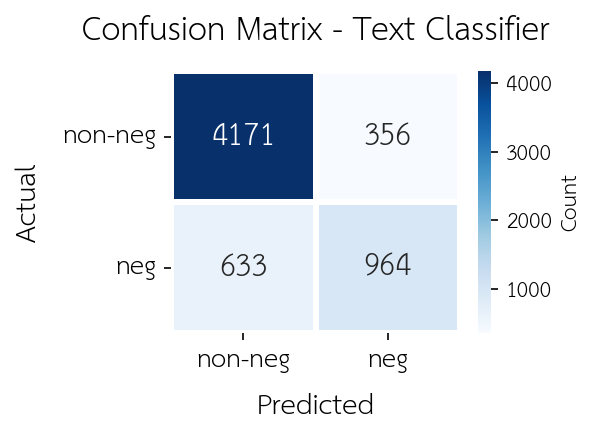

In [28]:
y_pred = text_clf.predict(X_test)

conf_mat = confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots(figsize=(4, 3), dpi=150)

sns.heatmap(conf_mat, annot=True, fmt="d", cmap='Blues',
            xticklabels=class_names, yticklabels=class_names,
            cbar_kws={'label': 'Count'}, linewidths=2, linecolor='white',
            annot_kws={'size': 14, 'weight': 'bold'})

plt.ylabel("Actual", fontsize=13, fontweight='bold', labelpad=10)
plt.xlabel("Predicted", fontsize=13, fontweight='bold', labelpad=10)
plt.title("Confusion Matrix - Text Classifier", fontsize=15, fontweight='bold', pad=15)

plt.xticks(rotation=0, fontsize=12)
plt.yticks(rotation=0, fontsize=12)

plt.tight_layout()
plt.show()

In [29]:
print("Results for Naive Bayes Classifier:")
print(classification_report(y_test, y_pred, target_names=class_names))

Results for Naive Bayes Classifier:
              precision    recall  f1-score   support

     non-neg       0.87      0.92      0.89      4527
         neg       0.73      0.60      0.66      1597

    accuracy                           0.84      6124
   macro avg       0.80      0.76      0.78      6124
weighted avg       0.83      0.84      0.83      6124



In [30]:
vectorizer = text_clf.named_steps['vect']
classifier = text_clf.named_steps['clf']

feature_names = vectorizer.get_feature_names_out()
feature_importance = classifier.feature_log_prob_

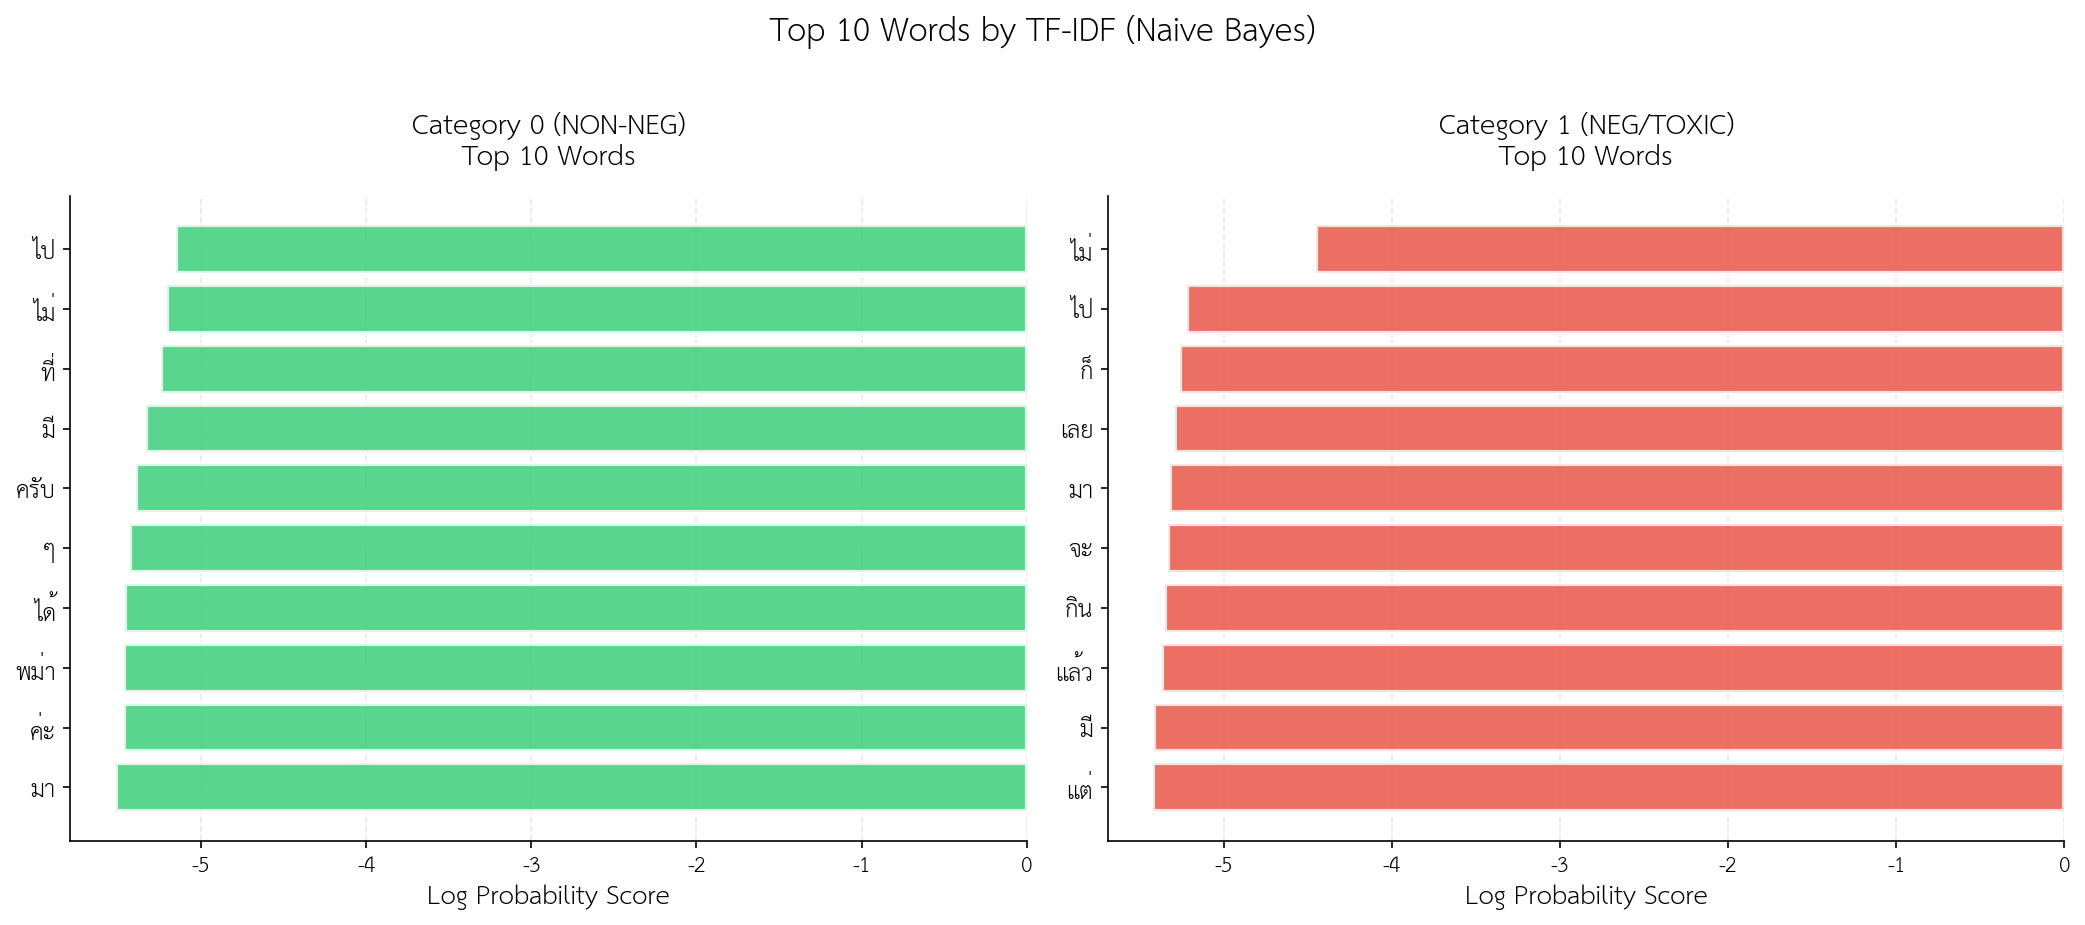

In [31]:
fig, axes = plt.subplots(1, 2, figsize=(14, 6), dpi=150)

top_indices_0 = feature_importance[0].argsort()[-10:]
top_words_0 = [feature_names[i] for i in top_indices_0]
top_scores_0 = [feature_importance[0][i] for i in top_indices_0]

axes[0].barh(range(10), top_scores_0, color='#2ecc71', alpha=0.8, edgecolor='white', linewidth=2)
axes[0].set_yticks(range(10))
axes[0].set_yticklabels(top_words_0, fontsize=11)
axes[0].set_xlabel('Log Probability Score', fontsize=12, fontweight='bold')
axes[0].set_title('Category 0 (NON-NEG)\nTop 10 Words', fontsize=13, fontweight='bold', pad=15)
axes[0].spines['top'].set_visible(False)
axes[0].spines['right'].set_visible(False)
axes[0].grid(axis='x', alpha=0.3, linestyle='--')
axes[0].set_axisbelow(True)

top_indices_1 = feature_importance[1].argsort()[-10:]
top_words_1 = [feature_names[i] for i in top_indices_1]
top_scores_1 = [feature_importance[1][i] for i in top_indices_1]

axes[1].barh(range(10), top_scores_1, color='#e74c3c', alpha=0.8, edgecolor='white', linewidth=2)
axes[1].set_yticks(range(10))
axes[1].set_yticklabels(top_words_1, fontsize=11)
axes[1].set_xlabel('Log Probability Score', fontsize=12, fontweight='bold')
axes[1].set_title('Category 1 (NEG/TOXIC)\nTop 10 Words', fontsize=13, fontweight='bold', pad=15)
axes[1].spines['top'].set_visible(False)
axes[1].spines['right'].set_visible(False)
axes[1].grid(axis='x', alpha=0.3, linestyle='--')
axes[1].set_axisbelow(True)

plt.suptitle('Top 10 Words by TF-IDF (Naive Bayes)', fontsize=15, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

## Linear SVC

In [32]:
svc_clf = Pipeline([
    ("vect", CountVectorizer(tokenizer=process_text, ngram_range=(1,2),token_pattern=None,min_df=2,max_features=10000)),
    ("tfidf", TfidfTransformer()),
    ("clf", LinearSVC()),
])

svc_clf.fit(X_train, y_train)
svc_clf.score(X_test, y_test)

0.8440561724363161

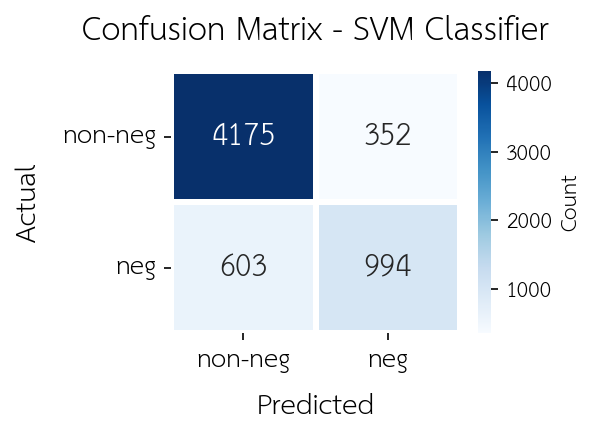

In [33]:
y_pred = svc_clf.predict(X_test)

conf_mat = confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots(figsize=(4, 3), dpi=150)

sns.heatmap(conf_mat, annot=True, fmt="d", cmap='Blues',
            xticklabels=class_names, yticklabels=class_names,
            cbar_kws={'label': 'Count'}, linewidths=2, linecolor='white',
            annot_kws={'size': 14, 'weight': 'bold'})

plt.ylabel("Actual", fontsize=13, fontweight='bold', labelpad=10)
plt.xlabel("Predicted", fontsize=13, fontweight='bold', labelpad=10)
plt.title("Confusion Matrix - SVM Classifier", fontsize=15, fontweight='bold', pad=15)

plt.xticks(rotation=0, fontsize=12)
plt.yticks(rotation=0, fontsize=12)

plt.tight_layout()
plt.show()

In [34]:
print("Results for SVM Classifier:")
print(classification_report(y_test, y_pred, target_names=class_names))

Results for SVM Classifier:
              precision    recall  f1-score   support

     non-neg       0.87      0.92      0.90      4527
         neg       0.74      0.62      0.68      1597

    accuracy                           0.84      6124
   macro avg       0.81      0.77      0.79      6124
weighted avg       0.84      0.84      0.84      6124



In [35]:
vectorizer_svm = svc_clf.named_steps['vect']
classifier_svm = svc_clf.named_steps['clf']

feature_names_svm = vectorizer_svm.get_feature_names_out()
coefficients = classifier_svm.coef_[0]

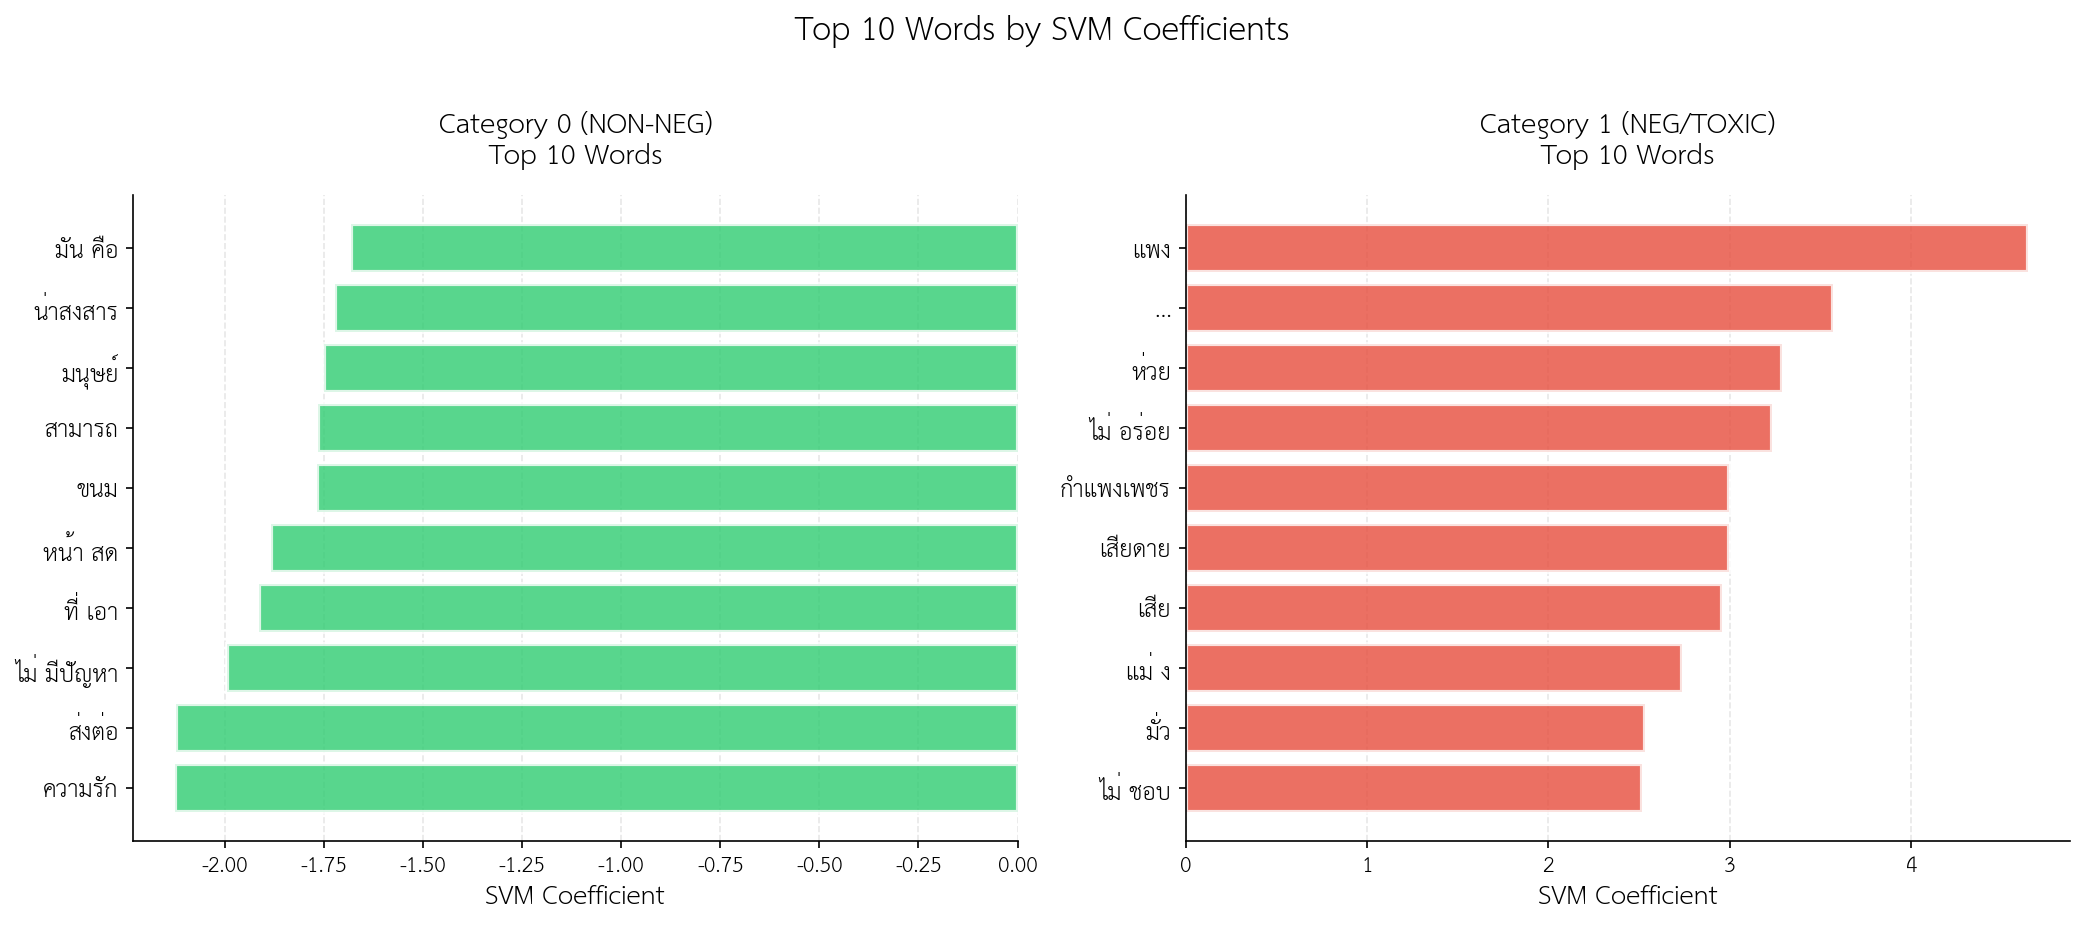

In [36]:
fig, axes = plt.subplots(1, 2, figsize=(14, 6), dpi=150)

top_indices_0_svm = coefficients.argsort()[:10]
top_words_0_svm = [feature_names_svm[i] for i in top_indices_0_svm]
top_coefs_0_svm = [coefficients[i] for i in top_indices_0_svm]

axes[0].barh(range(10), top_coefs_0_svm, color='#2ecc71', alpha=0.8, edgecolor='white', linewidth=2)
axes[0].set_yticks(range(10))
axes[0].set_yticklabels(top_words_0_svm, fontsize=11)
axes[0].set_xlabel('SVM Coefficient', fontsize=12, fontweight='bold')
axes[0].set_title('Category 0 (NON-NEG)\nTop 10 Words', fontsize=13, fontweight='bold', pad=15)
axes[0].spines['top'].set_visible(False)
axes[0].spines['right'].set_visible(False)
axes[0].grid(axis='x', alpha=0.3, linestyle='--')
axes[0].set_axisbelow(True)

top_indices_1_svm = coefficients.argsort()[-10:]
top_words_1_svm = [feature_names_svm[i] for i in top_indices_1_svm]
top_coefs_1_svm = [coefficients[i] for i in top_indices_1_svm]

axes[1].barh(range(10), top_coefs_1_svm, color='#e74c3c', alpha=0.8, edgecolor='white', linewidth=2)
axes[1].set_yticks(range(10))
axes[1].set_yticklabels(top_words_1_svm, fontsize=11)
axes[1].set_xlabel('SVM Coefficient', fontsize=12, fontweight='bold')
axes[1].set_title('Category 1 (NEG/TOXIC)\nTop 10 Words', fontsize=13, fontweight='bold', pad=15)
axes[1].spines['top'].set_visible(False)
axes[1].spines['right'].set_visible(False)
axes[1].grid(axis='x', alpha=0.3, linestyle='--')
axes[1].set_axisbelow(True)

plt.suptitle('Top 10 Words by SVM Coefficients', fontsize=15, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

## Logistic Regression

In [37]:
lr_clf = Pipeline([
    ("vect", CountVectorizer(tokenizer=process_text, ngram_range=(1,2), token_pattern=None)),
    ("tfidf", TfidfTransformer()),
    ("clf", LogisticRegression(max_iter=1000, random_state=42)),
])

lr_clf.fit(X_train, y_train)
lr_clf.score(X_test, y_test)

0.8365447419986937

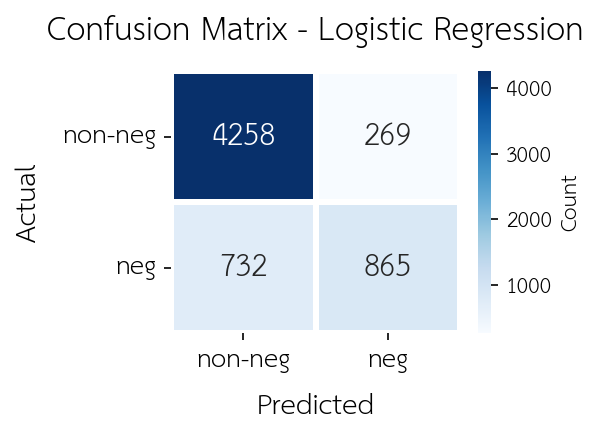

In [38]:
y_pred = lr_clf.predict(X_test)

conf_mat = confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots(figsize=(4, 3), dpi=150)

sns.heatmap(conf_mat, annot=True, fmt="d", cmap='Blues',
            xticklabels=class_names, yticklabels=class_names,
            cbar_kws={'label': 'Count'}, linewidths=2, linecolor='white',
            annot_kws={'size': 14, 'weight': 'bold'})

plt.ylabel("Actual", fontsize=13, fontweight='bold', labelpad=10)
plt.xlabel("Predicted", fontsize=13, fontweight='bold', labelpad=10)
plt.title("Confusion Matrix - Logistic Regression", fontsize=15, fontweight='bold', pad=15)

plt.xticks(rotation=0, fontsize=12)
plt.yticks(rotation=0, fontsize=12)

plt.tight_layout()
plt.show()

In [39]:
print("Results for Logistic Regression:")
print(classification_report(y_test, y_pred, target_names=class_names))

Results for Logistic Regression:
              precision    recall  f1-score   support

     non-neg       0.85      0.94      0.89      4527
         neg       0.76      0.54      0.63      1597

    accuracy                           0.84      6124
   macro avg       0.81      0.74      0.76      6124
weighted avg       0.83      0.84      0.83      6124



In [40]:
vectorizer_lr = lr_clf.named_steps['vect']
classifier_lr = lr_clf.named_steps['clf']

feature_names_lr = vectorizer_lr.get_feature_names_out()
coefficients_lr = classifier_lr.coef_[0]

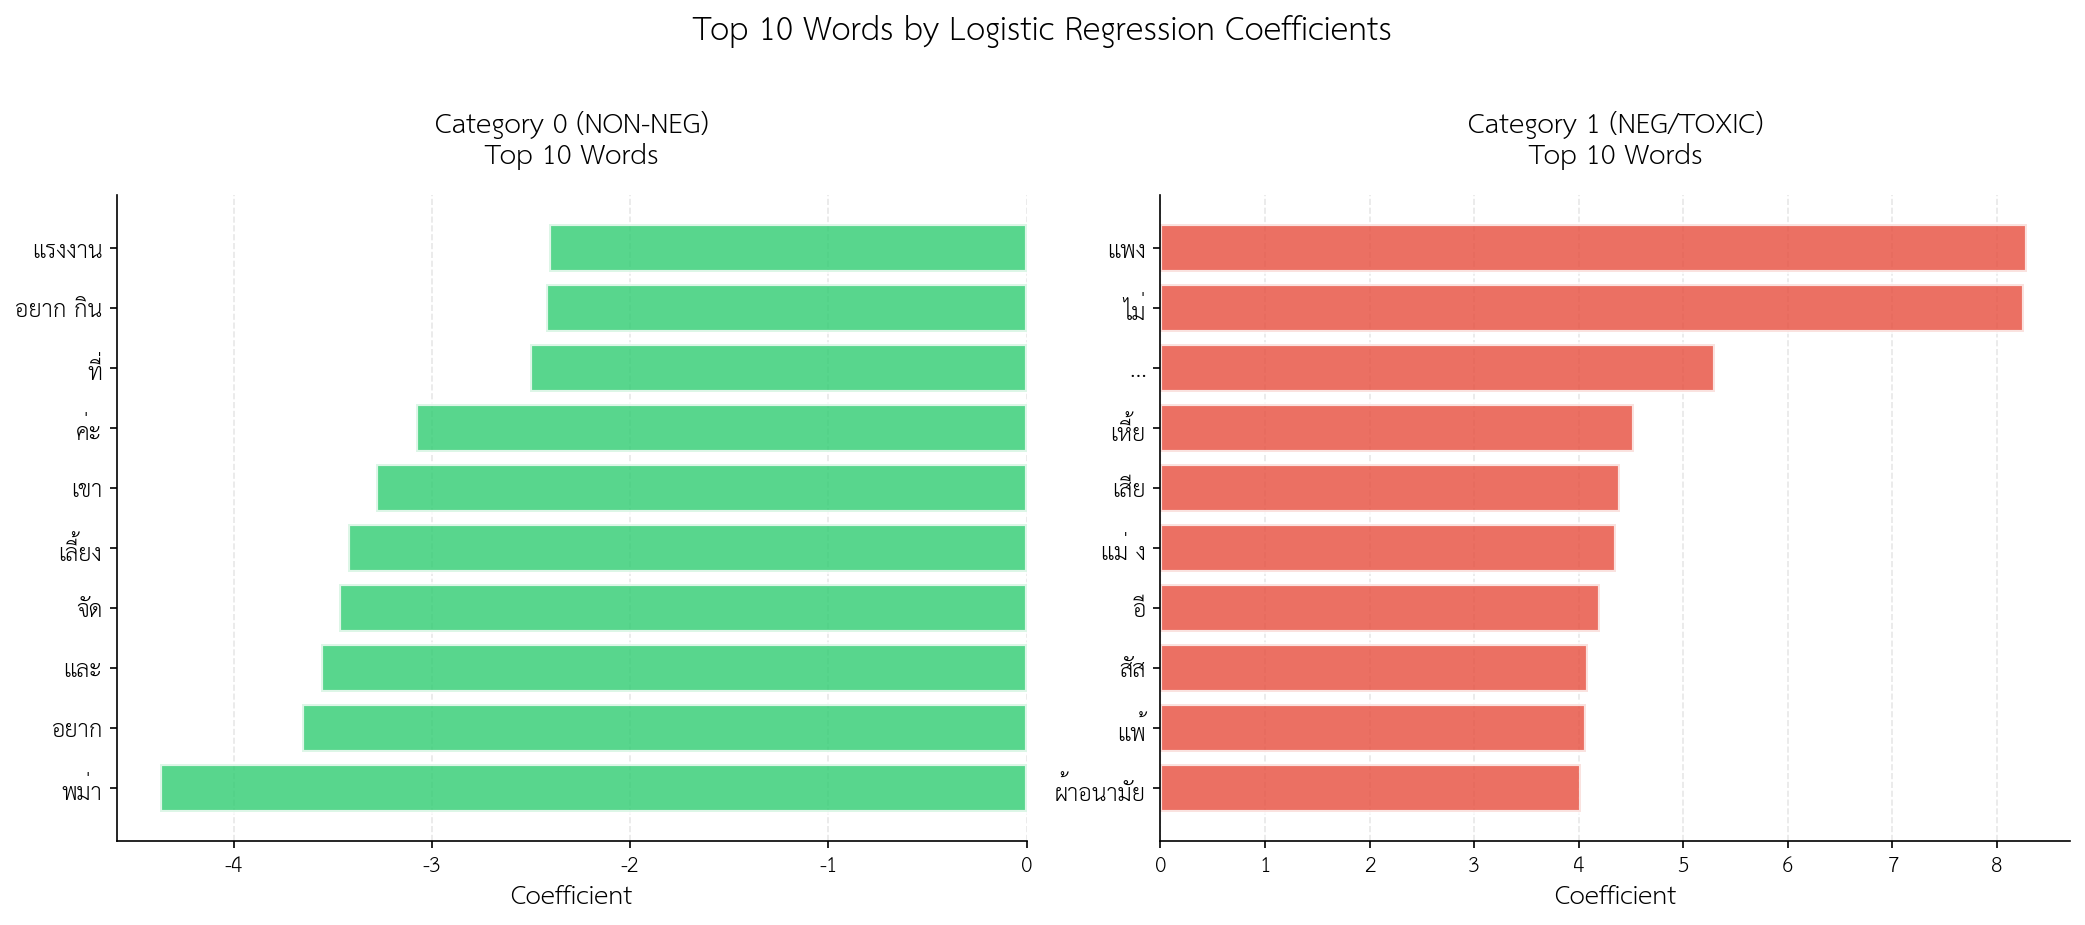

In [41]:
fig, axes = plt.subplots(1, 2, figsize=(14, 6), dpi=150)

top_indices_0_lr = coefficients_lr.argsort()[:10]
top_words_0_lr = [feature_names_lr[i] for i in top_indices_0_lr]
top_coefs_0_lr = [coefficients_lr[i] for i in top_indices_0_lr]

axes[0].barh(range(10), top_coefs_0_lr, color='#2ecc71', alpha=0.8, edgecolor='white', linewidth=2)
axes[0].set_yticks(range(10))
axes[0].set_yticklabels(top_words_0_lr, fontsize=11)
axes[0].set_xlabel('Coefficient', fontsize=12, fontweight='bold')
axes[0].set_title('Category 0 (NON-NEG)\nTop 10 Words', fontsize=13, fontweight='bold', pad=15)
axes[0].spines['top'].set_visible(False)
axes[0].spines['right'].set_visible(False)
axes[0].grid(axis='x', alpha=0.3, linestyle='--')
axes[0].set_axisbelow(True)

top_indices_1_lr = coefficients_lr.argsort()[-10:]
top_words_1_lr = [feature_names_lr[i] for i in top_indices_1_lr]
top_coefs_1_lr = [coefficients_lr[i] for i in top_indices_1_lr]

axes[1].barh(range(10), top_coefs_1_lr, color='#e74c3c', alpha=0.8, edgecolor='white', linewidth=2)
axes[1].set_yticks(range(10))
axes[1].set_yticklabels(top_words_1_lr, fontsize=11)
axes[1].set_xlabel('Coefficient', fontsize=12, fontweight='bold')
axes[1].set_title('Category 1 (NEG/TOXIC)\nTop 10 Words', fontsize=13, fontweight='bold', pad=15)
axes[1].spines['top'].set_visible(False)
axes[1].spines['right'].set_visible(False)
axes[1].grid(axis='x', alpha=0.3, linestyle='--')
axes[1].set_axisbelow(True)

plt.suptitle('Top 10 Words by Logistic Regression Coefficients', fontsize=15, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

## Random Forest

In [42]:
rf_clf = Pipeline([
    ("vect", CountVectorizer(tokenizer=process_text, ngram_range=(1,2), token_pattern=None)),
    ("tfidf", TfidfTransformer()),
    ("clf", RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)),
])

rf_clf.fit(X_train, y_train)
rf_clf.score(X_test, y_test)

0.8030698889614631

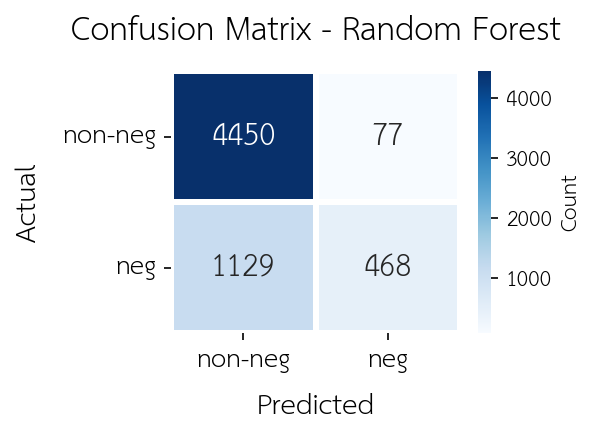

In [43]:
y_pred = rf_clf.predict(X_test)

conf_mat = confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots(figsize=(4, 3), dpi=150)

sns.heatmap(conf_mat, annot=True, fmt="d", cmap='Blues',
            xticklabels=class_names, yticklabels=class_names,
            cbar_kws={'label': 'Count'}, linewidths=2, linecolor='white',
            annot_kws={'size': 14, 'weight': 'bold'})

plt.ylabel("Actual", fontsize=13, fontweight='bold', labelpad=10)
plt.xlabel("Predicted", fontsize=13, fontweight='bold', labelpad=10)
plt.title("Confusion Matrix - Random Forest", fontsize=15, fontweight='bold', pad=15)

plt.xticks(rotation=0, fontsize=12)
plt.yticks(rotation=0, fontsize=12)

plt.tight_layout()
plt.show()

In [44]:
print("Results for Random Forest:")
print(classification_report(y_test, y_pred, target_names=class_names))

Results for Random Forest:
              precision    recall  f1-score   support

     non-neg       0.80      0.98      0.88      4527
         neg       0.86      0.29      0.44      1597

    accuracy                           0.80      6124
   macro avg       0.83      0.64      0.66      6124
weighted avg       0.81      0.80      0.76      6124



In [45]:
vectorizer_rf = rf_clf.named_steps['vect']
classifier_rf = rf_clf.named_steps['clf']

feature_names_rf = vectorizer_rf.get_feature_names_out()
importances_rf = classifier_rf.feature_importances_

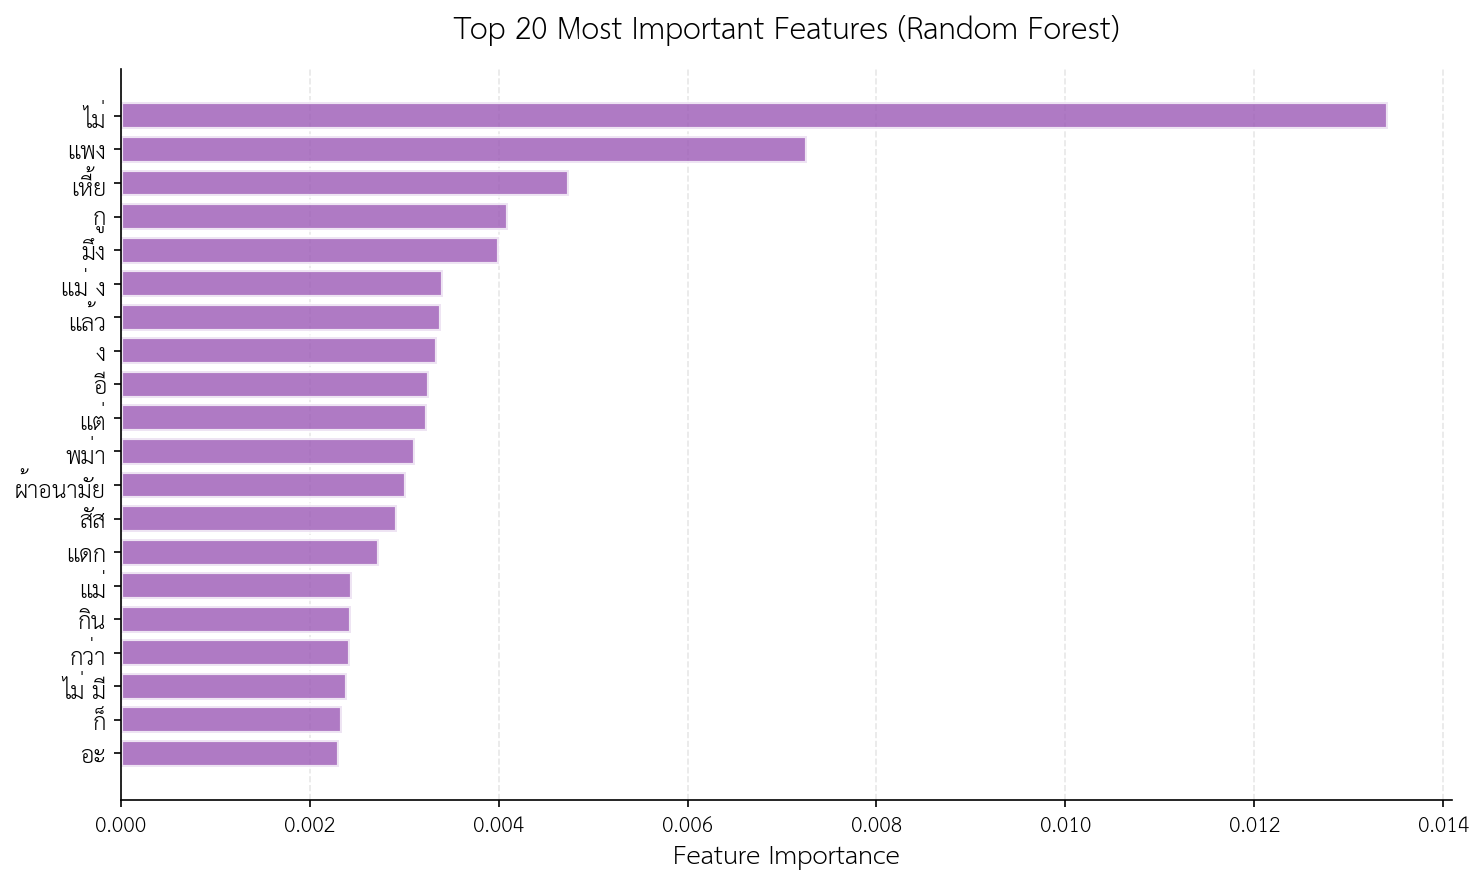

In [46]:
fig, ax = plt.subplots(figsize=(10, 6), dpi=150)

top_indices_rf = importances_rf.argsort()[-20:]
top_words_rf = [feature_names_rf[i] for i in top_indices_rf]
top_importances_rf = [importances_rf[i] for i in top_indices_rf]

ax.barh(range(20), top_importances_rf, color='#9b59b6', alpha=0.8, edgecolor='white', linewidth=2)
ax.set_yticks(range(20))
ax.set_yticklabels(top_words_rf, fontsize=11)
ax.set_xlabel('Feature Importance', fontsize=12, fontweight='bold')
ax.set_title('Top 20 Most Important Features (Random Forest)', fontsize=14, fontweight='bold', pad=15)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.grid(axis='x', alpha=0.3, linestyle='--')
ax.set_axisbelow(True)

plt.tight_layout()
plt.show()

## XGBoost

In [47]:
xgb_clf = Pipeline([
    ("vect", CountVectorizer(tokenizer=process_text, ngram_range=(1,2), token_pattern=None)),
    ("tfidf", TfidfTransformer()),
    ("clf", XGBClassifier(n_estimators=100, random_state=42, n_jobs=-1, eval_metric='logloss')),
])

xgb_clf.fit(X_train, y_train)
xgb_clf.score(X_test, y_test)

0.8393207054212932

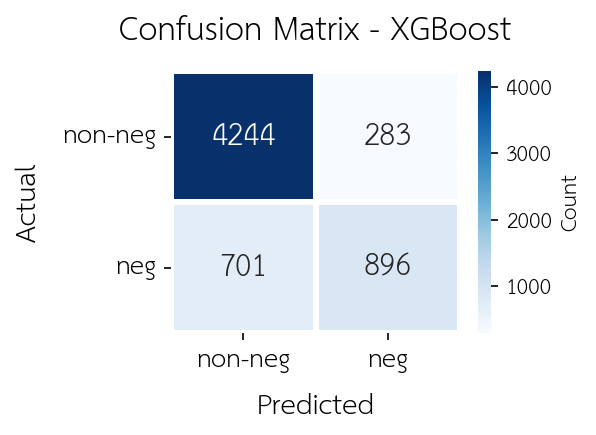

In [48]:
y_pred = xgb_clf.predict(X_test)

conf_mat = confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots(figsize=(4, 3), dpi=150)

sns.heatmap(conf_mat, annot=True, fmt="d", cmap='Blues',
            xticklabels=class_names, yticklabels=class_names,
            cbar_kws={'label': 'Count'}, linewidths=2, linecolor='white',
            annot_kws={'size': 14, 'weight': 'bold'})

plt.ylabel("Actual", fontsize=13, fontweight='bold', labelpad=10)
plt.xlabel("Predicted", fontsize=13, fontweight='bold', labelpad=10)
plt.title("Confusion Matrix - XGBoost", fontsize=15, fontweight='bold', pad=15)

plt.xticks(rotation=0, fontsize=12)
plt.yticks(rotation=0, fontsize=12)

plt.tight_layout()
plt.show()

In [49]:
print("Results for XGBoost:")
print(classification_report(y_test, y_pred, target_names=class_names))

Results for XGBoost:
              precision    recall  f1-score   support

     non-neg       0.86      0.94      0.90      4527
         neg       0.76      0.56      0.65      1597

    accuracy                           0.84      6124
   macro avg       0.81      0.75      0.77      6124
weighted avg       0.83      0.84      0.83      6124



In [50]:
vectorizer_xgb = xgb_clf.named_steps['vect']
classifier_xgb = xgb_clf.named_steps['clf']

feature_names_xgb = vectorizer_xgb.get_feature_names_out()
importances_xgb = classifier_xgb.feature_importances_

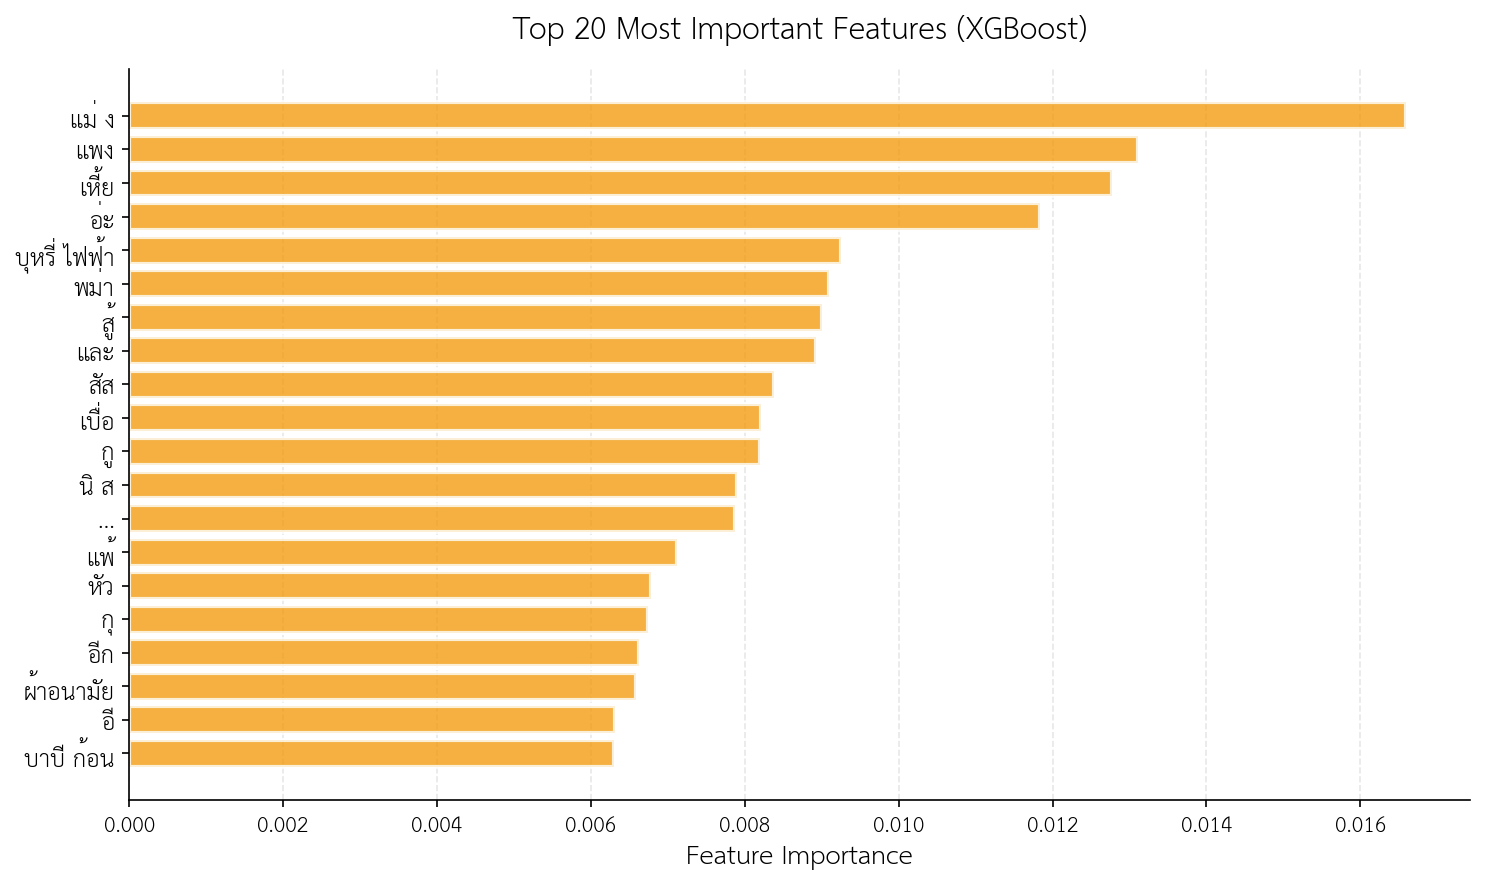

In [51]:
fig, ax = plt.subplots(figsize=(10, 6), dpi=150)

top_indices_xgb = importances_xgb.argsort()[-20:]
top_words_xgb = [feature_names_xgb[i] for i in top_indices_xgb]
top_importances_xgb = [importances_xgb[i] for i in top_indices_xgb]

ax.barh(range(20), top_importances_xgb, color='#f39c12', alpha=0.8, edgecolor='white', linewidth=2)
ax.set_yticks(range(20))
ax.set_yticklabels(top_words_xgb, fontsize=11)
ax.set_xlabel('Feature Importance', fontsize=12, fontweight='bold')
ax.set_title('Top 20 Most Important Features (XGBoost)', fontsize=14, fontweight='bold', pad=15)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.grid(axis='x', alpha=0.3, linestyle='--')
ax.set_axisbelow(True)

plt.tight_layout()
plt.show()

## Comparison

In [52]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

models = {
    'Naive Bayes': text_clf,
    'Linear SVC': svc_clf,
    'Logistic Regression': lr_clf,
    'Random Forest': rf_clf,
    'XGBoost': xgb_clf
}

results = []
for name, model in models.items():
    y_pred = model.predict(X_test)
    
    metrics = {
        'Model': name,
        'Accuracy': accuracy_score(y_test, y_pred),
        'Precision': precision_score(y_test, y_pred, average='weighted'),
        'Recall': recall_score(y_test, y_pred, average='weighted'),
        'F1-Score': f1_score(y_test, y_pred, average='weighted')
    }
    results.append(metrics)

results_df = pd.DataFrame(results)
print(results_df.to_string(index=False))
print(f"Best Model by Accuracy: {results_df.loc[results_df['Recall'].idxmax(), 'Model']} "
      f"({results_df['Recall'].max():.4f})")
print(f"Best Model by F1-Score: {results_df.loc[results_df['F1-Score'].idxmax(), 'Model']} "
      f"({results_df['F1-Score'].max():.4f})")

              Model  Accuracy  Precision   Recall  F1-Score
        Naive Bayes  0.838504   0.832265 0.838504  0.833233
         Linear SVC  0.844056   0.838510 0.844056  0.839509
Logistic Regression  0.836545   0.829701 0.836545  0.826665
      Random Forest  0.803070   0.813563 0.803070  0.764961
            XGBoost  0.839321   0.832613 0.839321  0.830769
Best Model by Accuracy: Linear SVC (0.8441)
Best Model by F1-Score: Linear SVC (0.8395)


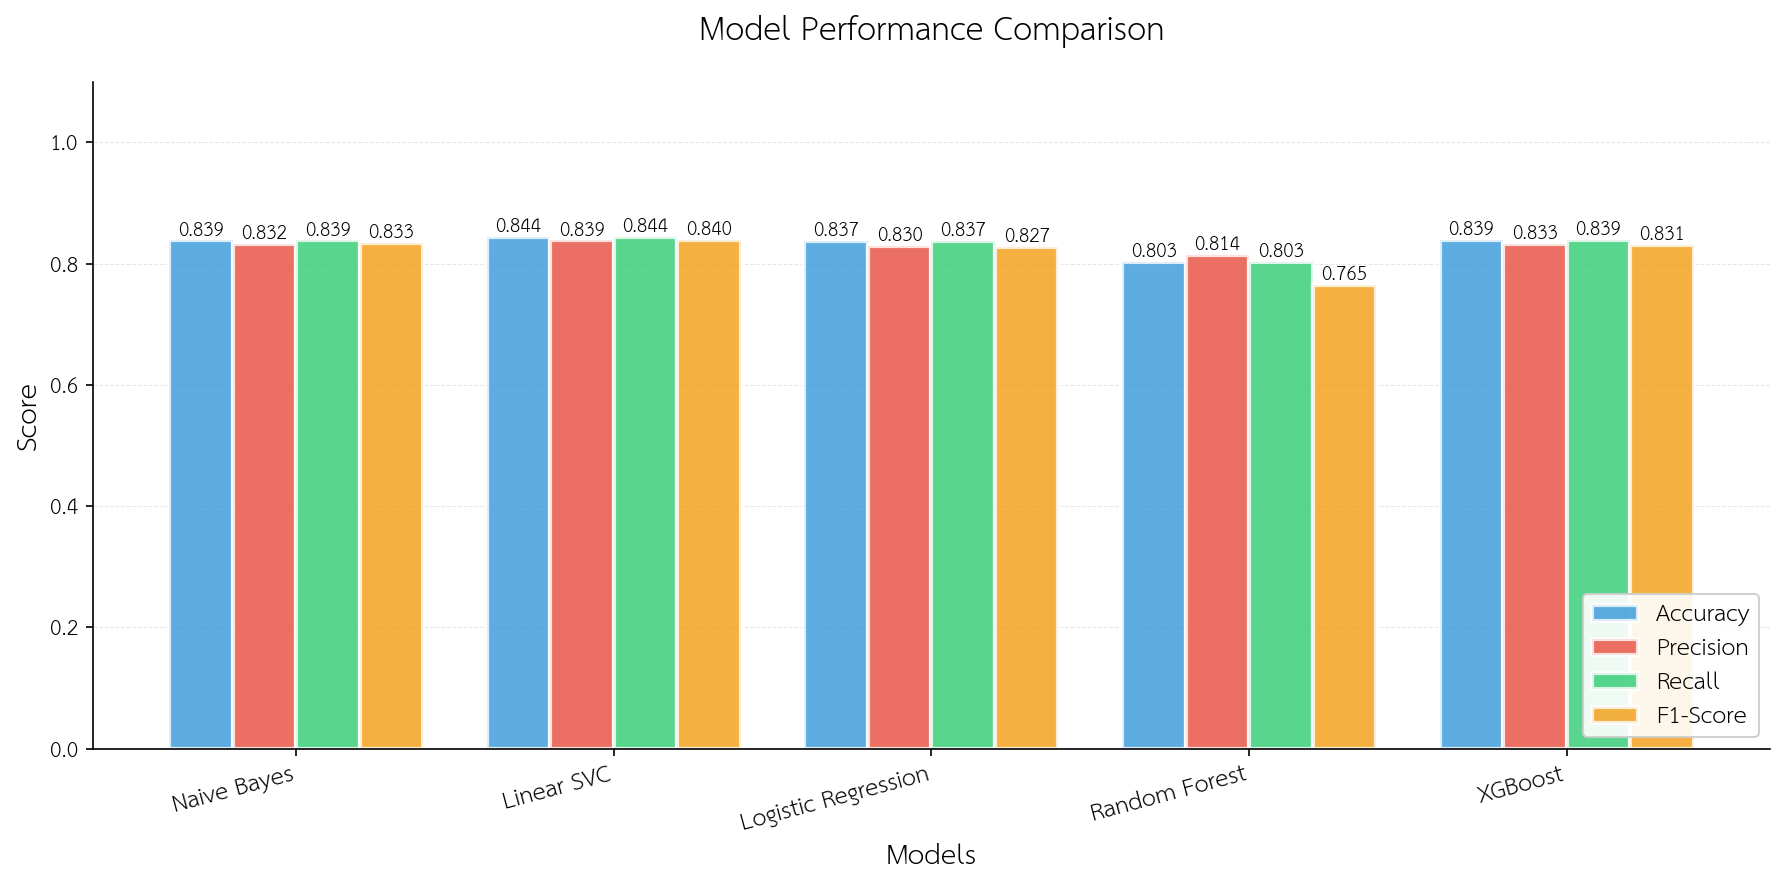

In [53]:
fig, ax = plt.subplots(figsize=(12, 6), dpi=150)

metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score']
x = np.arange(len(results_df))
width = 0.2

colors = ['#3498db', '#e74c3c', '#2ecc71', '#f39c12']

for i, metric in enumerate(metrics):
    offset = width * (i - 1.5)
    bars = ax.bar(x + offset, results_df[metric], width, 
                   label=metric, color=colors[i], alpha=0.8, 
                   edgecolor='white', linewidth=2)
    
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.3f}',
                ha='center', va='bottom', fontsize=9, fontweight='bold')

ax.set_xlabel('Models', fontsize=13, fontweight='bold')
ax.set_ylabel('Score', fontsize=13, fontweight='bold')
ax.set_title('Model Performance Comparison', fontsize=15, fontweight='bold', pad=20)
ax.set_xticks(x)
ax.set_xticklabels(results_df['Model'], fontsize=11, rotation=15, ha='right')
ax.legend(loc='lower right', fontsize=11, framealpha=0.9)
ax.set_ylim([0, 1.1])
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.grid(axis='y', alpha=0.3, linestyle='--', linewidth=0.5)
ax.set_axisbelow(True)

plt.tight_layout()
plt.show()

#### Model Improvement: Improving Recall for the `toxic (neg)` class.

1. Experiments with `class_weight`

In [ ]:
svc_balanced = Pipeline([
    ('vect', TfidfVectorizer(tokenizer=word_tokenize, ngram_range=(1, 2), min_df=5)),
    ('clf', LinearSVC(class_weight='balanced', random_state=42))
])

lr_balanced = Pipeline([
    ('vect', TfidfVectorizer(tokenizer=word_tokenize, ngram_range=(1, 2), min_df=5)),
    ('clf', LogisticRegression(class_weight='balanced', max_iter=1000, random_state=42))
])

svc_balanced.fit(X_train, y_train)
lr_balanced.fit(X_train, y_train)

print("Linear SVC (Balanced) Report:")
print(classification_report(y_test, svc_balanced.predict(X_test), target_names=class_names))
print("\nLogistic Regression (Balanced) Report:")
print(classification_report(y_test, lr_balanced.predict(X_test), target_names=class_names))

c:\Users\ananz\THAI-MOD-Multilingual-Online-Toxicity-Detection-System\.venv\Lib\site-packages\sklearn\feature_extraction\text.py:526: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
c:\Users\ananz\THAI-MOD-Multilingual-Online-Toxicity-Detection-System\.venv\Lib\site-packages\sklearn\feature_extraction\text.py:526: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


Linear SVC (Balanced) Report:
              precision    recall  f1-score   support

     non-neg       0.90      0.87      0.89      4527
         neg       0.67      0.72      0.70      1597

    accuracy                           0.84      6124
   macro avg       0.78      0.80      0.79      6124
weighted avg       0.84      0.84      0.84      6124


Logistic Regression (Balanced) Report:
              precision    recall  f1-score   support

     non-neg       0.91      0.85      0.88      4527
         neg       0.64      0.78      0.70      1597

    accuracy                           0.83      6124
   macro avg       0.78      0.81      0.79      6124
weighted avg       0.84      0.83      0.83      6124



2. Experiments with Oversampling (RandomOverSampler)

In [ ]:
svc_oversampled = ImbPipeline([
    ('vect', TfidfVectorizer(tokenizer=word_tokenize, ngram_range=(1, 2), min_df=5)),
    ('over', RandomOverSampler(random_state=42)),
    ('clf', LinearSVC(random_state=42))
])

svc_oversampled.fit(X_train, y_train)

print("Linear SVC (Oversampled) Report:")
print(classification_report(
    y_test, 
    svc_oversampled.predict(X_test), 
    target_names=class_names
))

c:\Users\ananz\THAI-MOD-Multilingual-Online-Toxicity-Detection-System\.venv\Lib\site-packages\sklearn\feature_extraction\text.py:526: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


Linear SVC (Oversampled) Report:
              precision    recall  f1-score   support

     non-neg       0.89      0.88      0.89      4527
         neg       0.68      0.70      0.69      1597

    accuracy                           0.83      6124
   macro avg       0.79      0.79      0.79      6124
weighted avg       0.84      0.83      0.84      6124



3. Threshold Tuning (Logistic Regression)

In [ ]:
# Probability of 'neg' class (index 1)
y_probs = lr_clf.predict_proba(X_test)[:, 1]
thresholds = [0.3, 0.4, 0.5]

for t in thresholds:
    y_pred_t = (y_probs >= t).astype(int)
    
    print(f"--- Threshold: {t} ---")
    print(classification_report(
        y_test, 
        y_pred_t, 
        target_names=class_names
    ))
    print("\n")

--- Threshold: 0.3 ---
              precision    recall  f1-score   support

     non-neg       0.92      0.82      0.87      4527
         neg       0.62      0.79      0.69      1597

    accuracy                           0.82      6124
   macro avg       0.77      0.81      0.78      6124
weighted avg       0.84      0.82      0.82      6124



--- Threshold: 0.4 ---
              precision    recall  f1-score   support

     non-neg       0.89      0.89      0.89      4527
         neg       0.69      0.68      0.69      1597

    accuracy                           0.84      6124
   macro avg       0.79      0.79      0.79      6124
weighted avg       0.84      0.84      0.84      6124



--- Threshold: 0.5 ---
              precision    recall  f1-score   support

     non-neg       0.85      0.94      0.89      4527
         neg       0.76      0.54      0.63      1597

    accuracy                           0.84      6124
   macro avg       0.81      0.74      0.76      6124
w

4. Recall Comparison (Neg Class)

                           Method  Recall (Toxic)
4  Logistic Regression (Balanced)  0.775830      
1  Linear SVC (Balanced)           0.723857      
2  Linear SVC (Oversampled)        0.701941      
5  LogReg (Threshold 0.4)          0.677520      
0  Linear SVC (Baseline)           0.622417      
3  Logistic Regression (Baseline)  0.541641      


C:\Users\ananz\AppData\Local\Temp\ipykernel_45948\3292942133.py:37: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


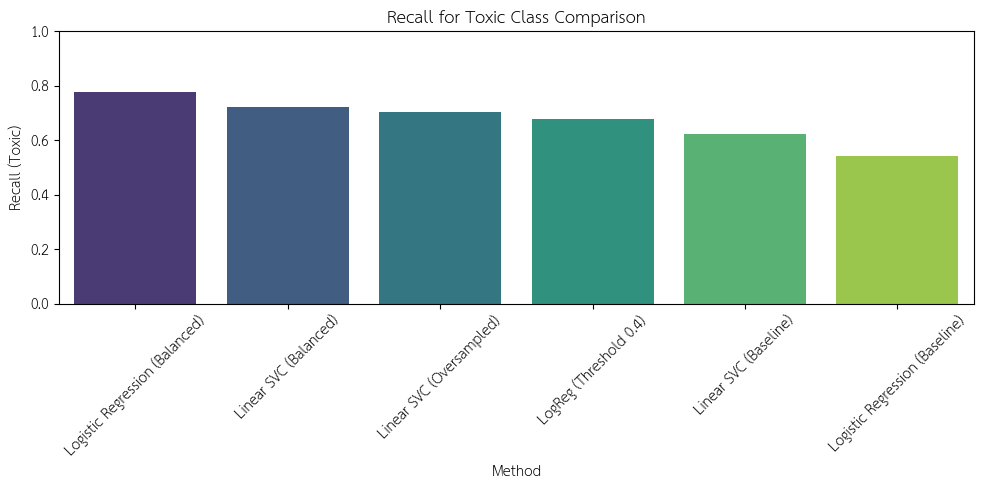

In [ ]:
comparison_results = []
models_to_compare = {
    'Linear SVC (Baseline)': svc_clf,
    'Linear SVC (Balanced)': svc_balanced,
    'Linear SVC (Oversampled)': svc_oversampled,
    'Logistic Regression (Baseline)': lr_clf,
    'Logistic Regression (Balanced)': lr_balanced,
    'LogReg (Threshold 0.4)': 'custom_threshold'
}

for name, model in models_to_compare.items():
    if name == 'LogReg (Threshold 0.4)':
        probs = lr_clf.predict_proba(X_test)[:, 1]
        preds = (probs >= 0.4).astype(int)
    else:
        preds = model.predict(X_test)
    
    recall_neg = recall_score(y_test, preds, pos_label=1) 
    comparison_results.append({
        'Method': name, 
        'Recall (Toxic)': recall_neg
    })

comp_df = pd.DataFrame(comparison_results)
print(comp_df.sort_values(by='Recall (Toxic)', ascending=False))

plt.figure(figsize=(10, 5))
sns.barplot(
    data=comp_df.sort_values(by='Recall (Toxic)', ascending=False), 
    x='Method', 
    y='Recall (Toxic)', 
    palette='viridis'
)

plt.title('Recall for Toxic Class Comparison')
plt.xticks(rotation=45)
plt.ylim(0, 1.0)
plt.tight_layout()
plt.show()

5. Feature Engineering (Basic Metadata)
- Testing if adding simple features like text length improves results.

In [61]:
class TextStats(BaseEstimator, TransformerMixin):
    def fit(self, x, y=None):
        return self
        
    def transform(self, posts):
        return pd.DataFrame([len(str(p)) for p in posts])

combined_features = Pipeline([
    ('features', FeatureUnion([
        ('tfidf', TfidfVectorizer(
            tokenizer=word_tokenize, 
            ngram_range=(1, 2), 
            min_df=5
        )),
        
        ('stats', Pipeline([
            ('stats', TextStats()),
            ('scaler', StandardScaler())
        ]))
    ])),
    
    ('clf', LinearSVC(class_weight='balanced', random_state=42))
])

combined_features.fit(X_train, y_train)

print("Pipeline with Stats (Length) Report:")
y_pred = combined_features.predict(X_test)
print(classification_report(y_test, y_pred, target_names=class_names))

c:\Users\ananz\THAI-MOD-Multilingual-Online-Toxicity-Detection-System\.venv\Lib\site-packages\sklearn\feature_extraction\text.py:526: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
c:\Users\ananz\THAI-MOD-Multilingual-Online-Toxicity-Detection-System\.venv\Lib\site-packages\sklearn\svm\_base.py:1258: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Pipeline with Stats (Length) Report:
              precision    recall  f1-score   support

     non-neg       0.90      0.87      0.89      4527
         neg       0.67      0.73      0.69      1597

    accuracy                           0.83      6124
   macro avg       0.78      0.80      0.79      6124
weighted avg       0.84      0.83      0.84      6124

